In [1]:

#Loading libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Suppressing warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Using TensorFlow backend.


In [2]:
#Load the model

In [3]:
#Global Variable
dict_clean_img = {} #BINARY IMAGE DICTIONAY
dict_img = {} #ORIGINAL IMAGE DICTIONARY

#Keras support channel first (1,28,28) only
keras.backend.set_image_data_format("channels_first")

In [17]:

#loading models
try:
    model = keras.models.load_model('./models/Digits-model.h5', compile=False)

except Exception as e:
    print('Model couldnot be loaded',e)

In [18]:
#defining functions for image processing

In [19]:
#%%
def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):
    '''
    image_resize : Function to resize images
    argument:
        image (Matrix)  : image to resize
        width (Integer) : width of the required image 
        height (Integer): height of required image
        inter (Method)  : Interpolation/Extrapolation method
    output:
        image (Matrix)  : image resized
    '''
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

'''
Evaluate New
'''
# supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    """
    >>> eval_expr('2^6')
    4
    >>> eval_expr('2**6')
    64
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)

'''
Workspace Detection
'''

def sort_contours(cnts, method="left-to-right"):
    '''
    sort_contours : Function to sort contours
    argument:
        cnts (array): image contours
        method(string) : sorting direction
    output:
        cnts(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def getBestShift(img):
    '''
    getBestShift : Function to calculate centre of mass and get the best shifts
    argument:
        img (array) : gray scale image
    output:
        shiftx, shifty: x,y shift direction
    '''
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    '''
    Shift : Function to shift the image in given direction 
    argument:
        img (array) : gray scale image
        sx, sy      : x, y direction
    output:
        shifted : shifted image
    '''
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

#%%
#Data Generator using tensorflow method
train_datagen = ImageDataGenerator(   
    data_format='channels_first',
    zca_whitening = True,
    rotation_range = 0.2)
#%%
def predict(img,x1,y1,x2,y2, proba = False, acc_thresh = 0.60):
    '''
    predict  : Function to predict the character
    argument:
        x1,y1(int,int)    : Top left corner point
        x2,y2(int,int)    : Bottom right corner point
        acc_thresh(0-1)   : Probability threshold for calling model_robusta
        proba(bool)       : If probability values is wanted in return
    output:
        c[index](int) : predicted character 
    
    '''
    gray = img[y1:y2, x1:x2]

    # Steps to remove noises in image due to cropping
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
    # Find the contours -  To check whether its disjoint character or noise
  
    contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        # Find the contours
        contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #Creating a mask of only zeros  
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        # Find the index of the largest contour
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        #Drawing those contours which are noises and then taking bitwise and
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']

    
    if (proba == True):
        return classes[0][ind]
    
    return c[ind]
#%%
def process_img (gray, resize_flag = 1, preproc = 0):
    '''
    process_img  : Function to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : image of character to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 : No erosion DIlation, 1 : Erosion, Dilation
    output:
        grayS (Matrix (0-1))      : Normalised image of character resized and processed
    
    '''    
    gray = gray.copy()
    
    #Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    #Removing rows and columns where all the pixels are black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Making the aspect ratio same before re-sizing
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    # Get the best shifts
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalize the image
    grayS = grayS/255
    
    return grayS

def extract_box(img, show=True):
    '''
    Function to extract the boxes in the ruled worksheet
    Input : Image with rectangle, show figures
    Output : Extract workspaces locations
    '''
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Otsu thresholding
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Defining a kernel length
    kernel_length = np.array(binary_image).shape[1]//80

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
    
    #Join horizontal and vertical images
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #Find and sort the contours
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area) #sorted area
    
    workspace_contours = []    
    #Find the correct boxes where area is between 40% and 50% of the largest rectangle
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    #A list to containg rectangle locs
    rectangle_locs =[]   
    
    #finding out locations of rectangle
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(7,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs

'''
Line Detection
'''

def find_good_contours_thres(conts, alpha = 0.002):
    '''
    Function to find threshold of good contours on basis of 10% of maximum area
    Input: Contours, threshold for removing noises
    Output: Contour area threshold
    
    For image dim 3307*4676
    alpha(text_segment) = 0.01
    alpha(extract_line) = 0.002
    '''
    #Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    #alpha is controlling paramter    
    thres = alpha * max(areas)[0]
    
    return thres

def extract_line(image, beta=0.7, alpha=0.002, show = True):
    '''
    Function to extracts the line from the image   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : Parameter to differentiate line
        alpha (0-1) : Parameter to select good contours
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    #Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Binary thresholding and inverting at 127
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    #Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    #Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #Dilating the cleaned image for better detection of line in cases where
    #exponents are little up the line
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ##find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    #Extending uppers and lowers indexes to avoid cutting of chars of lines
    #Extended more uppers by 33% as exponential might lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    #Combining rogue exponentials into their deserving lines. This happens when
    #exponential and lines are separated by some distance
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #For changing color of intermediate lines, keeping count
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        #print(left,right)
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]


def evaluate(df,A,B,X,Y):
    '''Function to evaluate mathematical equation and give bool output
    Input: Dataframe
           Values
    Output:
        Boolean T/F
    '''
    #Evaluating Expression
    actual = A*X*X+(B*Y)
    
    try:#If BODMAS is correct and Mathematically equation is correct
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        
        #looking for non digits in the start of the string for 
        #ignoring equal to's
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        #looking for broken 5's
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

        
        #This except block is fired when brackets are un necessarily used 
        #while writing the answerscripts and in strings
        matchesB_left = re.findall(r'\d\(\d', pred)
        matchesB_right = re.findall(r'\d\)\d', pred)
        
        if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
            for s in matchesB_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in matchesB_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        ans = eval_expr(pred)
        print(pred )
#        if(ans == actual):
#            val='Correct'
#        else:
#            val='Wrong'
#        print(ans, actual, val)
        if(df['pred_proba'].mean() < 0.75):
            return 5
        
    except Exception as e:
        print(pred,'-',e)
        return 5
    
    return actual==ans
	
def draw_contour(image, c, i):
	# compute the center of the contour area and draw a circle
	# representing the center
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
 
	# draw the countour number on the image
	cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
		1.0, (255, 255, 255), 2)
 
	# return the image with the contour number drawn on it
	return image

def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
    '''
    text_segment : Function to segment the characters
    Input:
        Box coordinates -X1,Y1,X2,Y2
        box_num - name of box
        line_name - name of line
        model - Deep Learning model to be used for prediction
        dict_clean - dictionary of clean box images
    Output :
        box_num - name of box
        line_name -name of line
        df_char - Dataframe of characters of that particular line
    '''
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1
    ## apply some dilation and erosion to join the gaps
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = find_good_contours_thres(contours, alpha=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
            
            #char_locs.append([x,y,x+w,y+h])     
            if(h<0.10*L_H and w<0.10*L_H):
                #print('Yes')
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h]) #Normalised location of char w.r.t box image
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [box_num,line_name,df_char]

In [7]:
#read the image

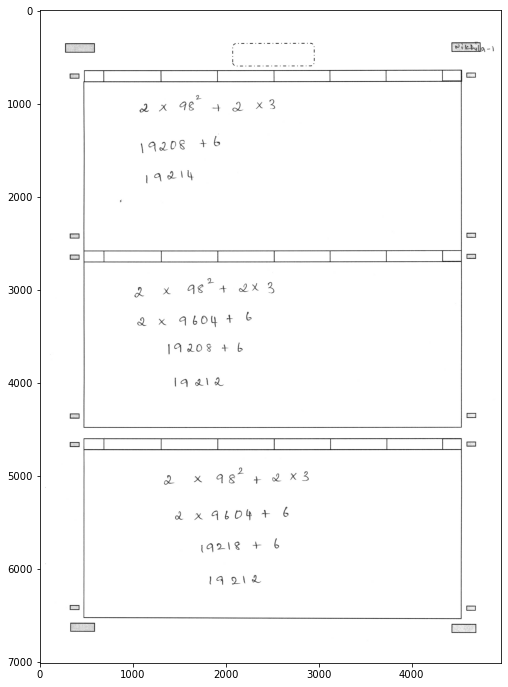

In [52]:
image_path = "data/sample_image.jpg"
A = 2
B = 2
X = 98
Y = 3

img = cv2.imread(image_path)
plt.figure(figsize=(12,12))
plt.imshow(img)

In [47]:
## extracting workspace

In [49]:
#Workspaces Detection
workspaces = extract_box(img)

<Figure size 504x648 with 0 Axes>

In [50]:
#line detection

In [51]:
#Defining dataframe for storing infos about every line detected
df_lines = pd.DataFrame()

for r,rect in enumerate(workspaces):
    #Cropping boxes for sending to line detection module
    box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    #Extracting lines present in the boxes
    cleaned_orig,y1s,y2s = extract_line(box, show=True)
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    
#        if(len(y1s)-len(y2s) == 0):
#            print('Lines in workspace-%d : %d' %(r, len(y1s)))
    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r

    df_lines= pd.concat([df_lines, df])

    dict_clean_img.update({r:cleaned_orig})
    dict_img.update({r:box})
    
    #print(df)

df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]

In [34]:
##exponential and character detection

In [35]:
#df_chars contains locations of all characters along with box_num and line name
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'], row['box_num'],row['line_name'], \
                 show=True), axis=1))

BOX 1
2298**24213
1920846
19214
BOX 2
2298**24223
22960446
1920846
19212
BOX 3
2298**24283
22960446
1921846
19212


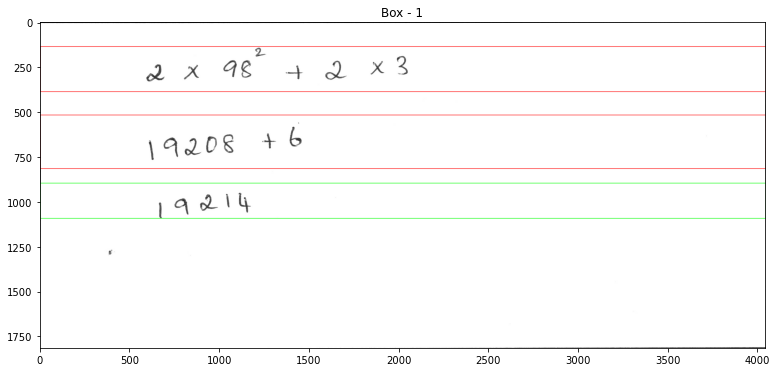

<Figure size 432x288 with 0 Axes>

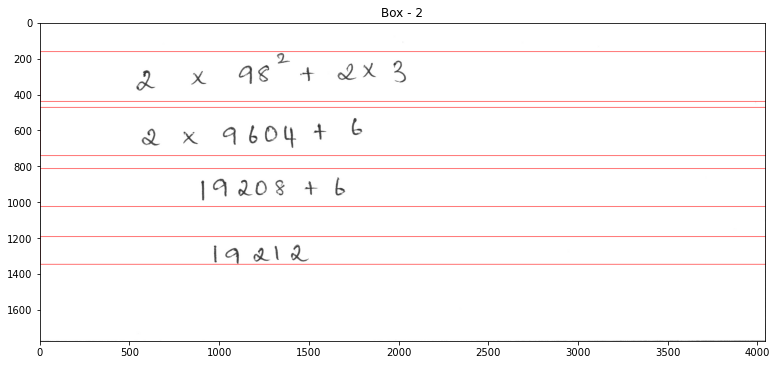

<Figure size 432x288 with 0 Axes>

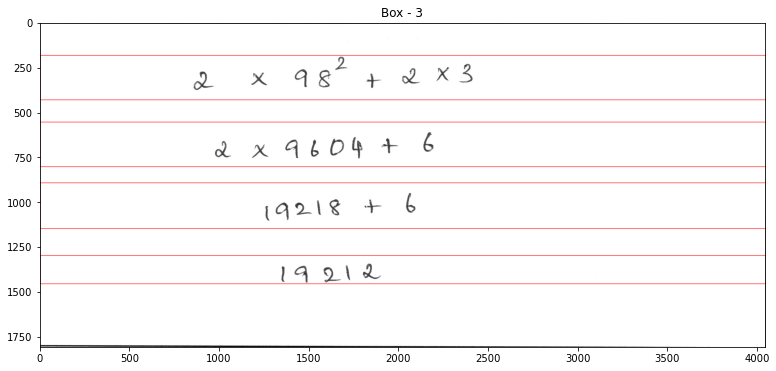

<Figure size 432x288 with 0 Axes>

In [27]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

#Area based threshold for detecting and removing noises
gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

#Keeping only those characters whose area of contours is above area threshold
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    print('BOX %d' %(bn+1))
    box_img = dict_clean_img[bn] #For Processing B/W image
    box_img_1 = dict_img[bn] #For saving results
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    df_l = df_lines[df_lines["box_num"]==bn].copy() #Defining dF with line info
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 # percent of original size
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)

    #Drawing rectangle on original Image
    df_l['line_status'] = list(df['line_status']) 
    df_l.apply(lambda c: cv2.rectangle(box_img_1, (c['x1'],c['y1']),(c['x2'],\
      c['y2']),(255*(c['line_status']==5),255*(c['line_status']==True),\
                                255*(c['line_status']==False)),2), axis=1)
    
    plt.figure(figsize=(13,7))
    plt.title('Box - %d' %(bn+1) )
    plt.imshow(cv2.cvtColor(box_img_1, cv2.COLOR_BGR2RGB))
    plt.figure()